### Reference
* https://github.com/wxie9/CARD

### Import Library

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
from argparse import Namespace
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Data Directory

In [2]:
feature_path = "../../data/merge_data_V6_eng_V1.csv"
region_feature_path = "../../data/nationwide_eng_V1.csv"

### Load Data

In [3]:
interest_rate = ["call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg"]
stock = ["KOSPI_index", "KOSDAQ_index", "NASDAQ_index"]
money_supply = ["M2_Korea", "M2_USA"]
liquidity = ["broad_liquidity"]
inflation = ["CPI_growth_rate"]
exchange_rate = ["USD_KRW_exchange_rate"]
gdp = ["real_GDP_growth_rate"]
construction = ["residential_building_start_status", "residential_building_permit_status"]
construction_production = ["construction_production_index_seasonally_adjusted"]

column = interest_rate + stock + money_supply + liquidity \
    + inflation + exchange_rate + gdp + \
    construction + construction_production

nf = pd.read_csv(region_feature_path)[:17].T.dropna()
nf.columns = nf.iloc[0]
nf = nf.iloc[1:].astype(float)

df = pd.read_csv(feature_path).T
df.columns = df.iloc[0]
df = df.iloc[1:]

df = df[column]
df = pd.concat([df,nf], axis = 1)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

date = 'Date'
df = df.reset_index(names=date) 
df[date] = pd.to_datetime(df[date]) 

df.reset_index(drop=True, inplace=True)
df.index.name = "num"

In [4]:
df.columns

Index(['Date', 'call_interest_rate', 'government_bond_3yr',
       'deposit_bank_loan_rate_avg', 'KOSPI_index', 'KOSDAQ_index',
       'NASDAQ_index', 'M2_Korea', 'M2_USA', 'broad_liquidity',
       'CPI_growth_rate', 'USD_KRW_exchange_rate', 'real_GDP_growth_rate',
       'residential_building_start_status',
       'residential_building_permit_status',
       'construction_production_index_seasonally_adjusted',
       'Seoul_apartment_sale_price_index', 'Busan_apartment_sale_price_index',
       'Daegu_apartment_sale_price_index',
       'Incheon_apartment_sale_price_index',
       'Gwangju_apartment_sale_price_index',
       'Daejeon_apartment_sale_price_index',
       'Ulsan_apartment_sale_price_index', 'Sejong_apartment_sale_price_index',
       'Gyeonggi_apartment_sale_price_index',
       'Gangwon_apartment_sale_price_index',
       'Chungbuk_apartment_sale_price_index',
       'Chungnam_apartment_sale_price_index',
       'Jeonbuk_apartment_sale_price_index',
       'Jeonnam_apa

In [5]:
target_column = [
    "Seoul",
    "Busan",
    "Daegu",
    "Incheon",
    "Gwangju",
    "Daejeon",
    "Ulsan",
    "Sejong",
    "Gyeonggi",
    "Gangwon",
    "Chungbuk",
    "Chungnam",
    "Jeonbuk",
    "Jeonnam",
    "Gyeongbuk",
    "Gyeongnam",
    "Jeju",
]

In [6]:
train_df

NameError: name 'train_df' is not defined

In [197]:
train_df.columns

Index(['Date', 'call_interest_rate', 'government_bond_3yr',
       'deposit_bank_loan_rate_avg', 'KOSPI_index', 'KOSDAQ_index',
       'NASDAQ_index', 'M2_Korea', 'M2_USA', 'broad_liquidity',
       'CPI_growth_rate', 'USD_KRW_exchange_rate', 'real_GDP_growth_rate',
       'residential_building_start_status',
       'residential_building_permit_status',
       'construction_production_index_seasonally_adjusted',
       'Seoul_apartment_sale_price_index', 'Busan_apartment_sale_price_index',
       'Daegu_apartment_sale_price_index',
       'Incheon_apartment_sale_price_index',
       'Gwangju_apartment_sale_price_index',
       'Daejeon_apartment_sale_price_index',
       'Ulsan_apartment_sale_price_index', 'Sejong_apartment_sale_price_index',
       'Gyeonggi_apartment_sale_price_index',
       'Gangwon_apartment_sale_price_index',
       'Chungbuk_apartment_sale_price_index',
       'Chungnam_apartment_sale_price_index',
       'Jeonbuk_apartment_sale_price_index',
       'Jeonnam_apa

In [198]:
from scipy.stats import ks_2samp

# Feature와 Target 간 KS 테스트
for feature in train_df.columns[1:]:
    statistic, p_value = ks_2samp(train_df[nf.columns[0]], train_df[feature])
    print(f"Feature: {feature}, KS Statistic: {statistic:.4f}, p-value: {p_value:.4f}")


Feature: call_interest_rate, KS Statistic: 1.0000, p-value: 0.0000
Feature: government_bond_3yr, KS Statistic: 1.0000, p-value: 0.0000
Feature: deposit_bank_loan_rate_avg, KS Statistic: 1.0000, p-value: 0.0000
Feature: KOSPI_index, KS Statistic: 1.0000, p-value: 0.0000
Feature: KOSDAQ_index, KS Statistic: 1.0000, p-value: 0.0000
Feature: NASDAQ_index, KS Statistic: 1.0000, p-value: 0.0000
Feature: M2_Korea, KS Statistic: 1.0000, p-value: 0.0000
Feature: M2_USA, KS Statistic: 1.0000, p-value: 0.0000
Feature: broad_liquidity, KS Statistic: 1.0000, p-value: 0.0000
Feature: CPI_growth_rate, KS Statistic: 1.0000, p-value: 0.0000
Feature: USD_KRW_exchange_rate, KS Statistic: 1.0000, p-value: 0.0000
Feature: real_GDP_growth_rate, KS Statistic: 1.0000, p-value: 0.0000
Feature: residential_building_start_status, KS Statistic: 1.0000, p-value: 0.0000
Feature: residential_building_permit_status, KS Statistic: 1.0000, p-value: 0.0000
Feature: construction_production_index_seasonally_adjusted, KS S

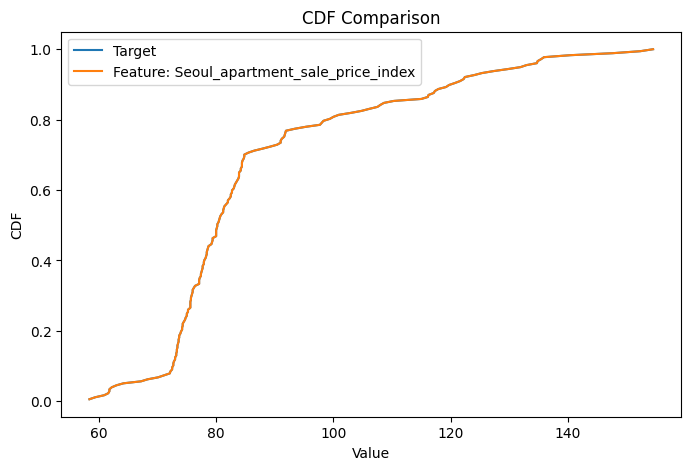

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cumfreq

# Target과 Feature의 CDF 비교
def plot_cdf(data, label):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    plt.plot(sorted_data, cdf, label=label)

plt.figure(figsize=(8, 5))

# Target의 CDF
plot_cdf(train_df[nf.columns[0]], label='Target')

# Feature들의 CDF
for feature in columns_to_use:
    plot_cdf(train_df[feature], label=f'Feature: {feature}')

plt.xlabel('Value')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF Comparison')
plt.show()


### CARD

In [9]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from einops import rearrange

In [8]:
%pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
__all__ = ['CARD']

class Transpose(nn.Module):
    def __init__(self, *dims, contiguous=False): 
        super().__init__()
        self.dims, self.contiguous = dims, contiguous
    def forward(self, x):
        if self.contiguous: return x.transpose(*self.dims).contiguous()
        else: return x.transpose(*self.dims)



class Model(nn.Module):
    def __init__(self, config, **kwargs):
        
        super().__init__()    
        self.model = CARDformer(config)
    def forward(self, x, *args, **kwargs):    

        x = x.permute(0,2,1)    
        x= self.model(x)
        x = x.permute(0,2,1)   
        return x
    
    
    
    
    
class CARDformer(nn.Module):
    def __init__(self, 
                 config,**kwargs):
        
        super().__init__()
        
        self.patch_len  = config.patch_len
        self.stride = config.stride
        self.d_model = config.d_model
        
        patch_num = int((config.seq_len - self.patch_len)/self.stride + 1)
        self.patch_num = patch_num
        self.W_pos_embed = nn.Parameter(torch.randn(patch_num,config.d_model)*1e-2)
        self.model_token_number = 0
        
        if self.model_token_number > 0:
            self.model_token = nn.Parameter(torch.randn(config.enc_in,self.model_token_number,config.d_model)*1e-2)
        
        
        self.total_token_number = (self.patch_num  + self.model_token_number + 1)
        config.total_token_number = self.total_token_number
             
        self.W_input_projection = nn.Linear(self.patch_len, config.d_model)  
        self.input_dropout  = nn.Dropout(config.dropout) 
        
                
        self.use_statistic = config.use_statistic
        self.W_statistic = nn.Linear(2,config.d_model) 
        self.cls = nn.Parameter(torch.randn(1,config.d_model)*1e-2)
        
        
        

        self.W_out = nn.Linear((patch_num+1+self.model_token_number)*config.d_model, config.pred_len) 

        

        
        self.Attentions_over_token = nn.ModuleList([Attenion(config) for i in range(config.e_layers)])
        self.Attentions_over_channel = nn.ModuleList([Attenion(config,over_hidden = True) for i in range(config.e_layers)])
        self.Attentions_mlp = nn.ModuleList([nn.Linear(config.d_model,config.d_model)  for i in range(config.e_layers)])
        self.Attentions_dropout = nn.ModuleList([nn.Dropout(config.dropout)  for i in range(config.e_layers)])
        self.Attentions_norm = nn.ModuleList([nn.Sequential(Transpose(1,2), nn.BatchNorm1d(config.d_model,momentum = config.momentum), Transpose(1,2)) for i in range(config.e_layers)])       
            
        

        

    def forward(self, z,*args, **kwargs):     

        b,c,s = z.shape
        
        
        z_mean = torch.mean(z,dim = (-1),keepdims = True)
        z_std = torch.std(z,dim = (-1),keepdims = True)
        z =  (z - z_mean)/(z_std + 1e-4)

      
            
        zcube = z.unfold(dimension=-1, size=self.patch_len, step=self.stride)                 
        z_embed = self.input_dropout(self.W_input_projection(zcube))+ self.W_pos_embed 
        
        
        if self.use_statistic:
            
            z_stat = torch.cat((z_mean,z_std),dim = -1)
            if z_stat.shape[-2]>1:
                z_stat = (z_stat - torch.mean(z_stat,dim =-2,keepdims = True))/( torch.std(z_stat,dim =-2,keepdims = True)+1e-4)
            z_stat = self.W_statistic(z_stat)
            z_embed = torch.cat((z_stat.unsqueeze(-2),z_embed),dim = -2) 
        else:
            cls_token = self.cls.repeat(z_embed.shape[0],z_embed.shape[1],1,1)
            z_embed = torch.cat((cls_token,z_embed),dim = -2) 

        inputs = z_embed
        b,c,t,h = inputs.shape 
        for a_2,a_1,mlp,drop,norm  in zip(self.Attentions_over_token, self.Attentions_over_channel,self.Attentions_mlp ,self.Attentions_dropout,self.Attentions_norm ):
            output_1 = a_1(inputs.permute(0,2,1,3)).permute(0,2,1,3)
            output_2 = a_2(output_1)
            outputs = drop(mlp(output_1+output_2))+inputs
            outputs = norm(outputs.reshape(b*c,t,-1)).reshape(b,c,t,-1) 
            inputs = outputs
        

        z_out = self.W_out(outputs.reshape(b,c,-1))  
        z = z_out *(z_std+1e-4)  + z_mean 
        return z
    

class Attenion(nn.Module):
    def __init__(self,config, over_hidden = False,trianable_smooth = False, *args, **kwargs):
        super().__init__()

        
        self.over_hidden = over_hidden
        self.n_heads = config.n_heads
        self.c_in = config.enc_in
        self.qkv = nn.Linear(config.d_model, config.d_model * 3, bias=True)
        
        
    
        self.attn_dropout = nn.Dropout(config.dropout)
        self.head_dim = config.d_model // config.n_heads
        

        # self.dropout_mlp = nn.Dropout(config.dropout)
        # self.mlp = nn.Linear( config.d_model,  config.d_model)
        
        

        self.norm_post1  = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(config.d_model,momentum = config.momentum), Transpose(1,2))
        self.norm_post2  = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(config.d_model,momentum = config.momentum), Transpose(1,2))
        
        self.norm_attn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(config.d_model,momentum = config.momentum), Transpose(1,2))
        
        
        self.dp_rank = config.dp_rank
        self.dp_k = nn.Linear(self.head_dim, self.dp_rank)
        self.dp_v = nn.Linear(self.head_dim, self.dp_rank)
        
        
        self.ff_1 = nn.Sequential(nn.Linear(config.d_model, config.d_ff, bias=True),
                        nn.GELU(),
                        nn.Dropout(config.dropout),
                        nn.Linear(config.d_ff, config.d_model, bias=True)
                       )
        
        self.ff_2= nn.Sequential(nn.Linear(config.d_model, config.d_ff, bias=True),
                        nn.GELU(),
                        nn.Dropout(config.dropout),
                        nn.Linear(config.d_ff, config.d_model, bias=True)
                                )     
        self.merge_size = config.merge_size
        # if not trianable_smooth:
        ema_size = max(config.enc_in,config.total_token_number,config.dp_rank)
        ema_matrix = torch.zeros((ema_size,ema_size))
        alpha = config.alpha
        ema_matrix[0][0] = 1
        for i in range(1,config.total_token_number):
            for j in range(i):
                ema_matrix[i][j] =  ema_matrix[i-1][j]*(1-alpha)
            ema_matrix[i][i] = alpha
        self.register_buffer('ema_matrix',ema_matrix)


       
    def ema(self,src):
        return torch.einsum('bnhad,ga ->bnhgd',src,self.ema_matrix[:src.shape[-2],:src.shape[-2]])
        
        
#     def ema_trianable(self,src):
#         alpha = F.sigmoid(self.alpha)
        
#         weights = alpha * (1 - alpha) ** self.arange[-src.shape[-2]:]
 

#         w_f = torch.fft.rfft(weights,n = src.shape[-2]*2)
#         src_f = torch.fft.rfft(src.float(),dim = -2,n = src.shape[-2]*2)    
#         src_f = (src_f.permute(0,1,2,4,3)*w_f)
#         src1 =torch.fft.irfft(src_f.float(),dim = -1,n=src.shape[-2]*2)[...,:src.shape[-2]].permute(0,1,2,4,3)#.half()
#         return src1



    def dynamic_projection(self,src,mlp):
        src_dp = mlp(src)
        src_dp = F.softmax(src_dp,dim = -1)
        src_dp = torch.einsum('bnhef,bnhec -> bnhcf',src,src_dp)
        return src_dp
        

        
        
    def forward(self, src, *args,**kwargs):


        B,nvars, H, C, = src.shape
        


        
        
        qkv = self.qkv(src).reshape(B,nvars, H, 3, self.n_heads, C // self.n_heads).permute(3, 0, 1,4, 2, 5)
   

        q, k, v = qkv[0], qkv[1], qkv[2]
    
        if not self.over_hidden: 
        
            attn_score_along_token = torch.einsum('bnhed,bnhfd->bnhef', self.ema(q), self.ema(k))/ self.head_dim ** -0.5

            attn_along_token = self.attn_dropout(F.softmax(attn_score_along_token, dim=-1) )
   
            output_along_token = torch.einsum('bnhef,bnhfd->bnhed', attn_along_token, v)


            
        else:

            v_dp,k_dp = self.dynamic_projection(v,self.dp_v) , self.dynamic_projection(k,self.dp_k)
            attn_score_along_token = torch.einsum('bnhed,bnhfd->bnhef', self.ema(q), self.ema(k_dp))/ self.head_dim ** -0.5
            
            attn_along_token = self.attn_dropout(F.softmax(attn_score_along_token, dim=-1) )
            output_along_token = torch.einsum('bnhef,bnhfd->bnhed', attn_along_token, v_dp)

        
        
        attn_score_along_hidden = torch.einsum('bnhae,bnhaf->bnhef', q,k)/ q.shape[-2] ** -0.5
        attn_along_hidden = self.attn_dropout(F.softmax(attn_score_along_hidden, dim=-1) )    
        output_along_hidden = torch.einsum('bnhef,bnhaf->bnhae', attn_along_hidden, v)



        merge_size = self.merge_size

        output1 = rearrange(output_along_token.reshape(B*nvars,-1,self.head_dim),
                            'bn (hl1 hl2 hl3) d -> bn  hl2 (hl3 hl1) d', 
                            hl1 = self.n_heads//merge_size, hl2 = output_along_token.shape[-2] ,hl3 = merge_size
                            ).reshape(B*nvars,-1,self.head_dim*self.n_heads)
        
        
        output2 = rearrange(output_along_hidden.reshape(B*nvars,-1,self.head_dim),
                            'bn (hl1 hl2 hl3) d -> bn  hl2 (hl3 hl1) d', 
                            hl1 = self.n_heads//merge_size, hl2 = output_along_token.shape[-2] ,hl3 = merge_size
                            ).reshape(B*nvars,-1,self.head_dim*self.n_heads)
        

        output1 = self.norm_post1(output1)
        output1 = output1.reshape(B,nvars, -1, self.n_heads * self.head_dim)
        output2 = self.norm_post2(output2)
        output2 = output2.reshape(B,nvars, -1, self.n_heads * self.head_dim)





        src2 =  self.ff_1(output1)+self.ff_2(output2)
        
        
        src = src + src2
        src = src.reshape(B*nvars, -1, self.n_heads * self.head_dim)
        src = self.norm_attn(src)

        src = src.reshape(B,nvars, -1, self.n_heads * self.head_dim)
        return src
    

### Tools for Prediction

In [14]:
def standardization(train_df, test_df, not_col, target): 
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_dict = {}
    std_dict = {}
    
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
        if x in target:
            mean_dict[x] = mean
            std_dict[x] = std
    return train_df_, test_df_, mean_dict, std_dict

def time_slide_df(df, window_size, forecast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0] - window_size - forecast_size + 1):
        # x: features from the past window_size (including columns)
        x = df_.loc[idx:idx+window_size-1, target].values 
        # get target value for future forecast size 
        y = df_.loc[idx+window_size:idx+window_size+forecast_size-1, target].values
        # get date value for future forecast size 
        date_ = df_.loc[idx+window_size:idx+window_size+forecast_size-1, date].values
        
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

### Common Experiment Setting

In [15]:
window_size = 3
forecast_size= 3 

train_df = df[0:177]
test_df = df[177-forecast_size:]
test_df.reset_index(drop=True, inplace=True)
test_df.index.name = "num"

### Train and Save model (Input V1: Variables used in MLP of FA-SEM)
* input: "call_interest_rate", "real_GDP_growth_rate", "residential_building_start_status", f"{target}"
* window_size = 3
* forecast_size= 3 

In [26]:
### Experiment Setting
version = "V1"
batch_size = 16
epoch_ = 500
lr = 0.001
patience = 20  # easrly stopping

columns_to_use = ["call_interest_rate", "real_GDP_growth_rate", "residential_building_start_status"] \
                    + nf.columns.tolist()
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len = window_size,              # 입력 시퀀스 길이
    patch_len = 3,                      # 각 패치의 길이
    stride = 2,                         # 패치 간격
    d_model = 128,                      # 모델의 hidden dimension
    pred_len = forecast_size,           # 예측 길이
    dropout = 0.1,                      # 드롭아웃 비율
    e_layers = 4,                       # 인코더 레이어 수
    n_heads = 8,                        # 멀티헤드 어텐션의 헤드 수
    use_statistic = True,               # 통계치 사용 여부
    total_token_number = 3,             # 총 토큰 수
    d_ff = 256,                         # Feedforward network의 차원
    momentum = 0.1,                     # 배치 정규화의 모멘템
    alpha = 0.3,                        # EMA 계수
    dp_rank = 16,                       # 동적 프로젝션의 랭크
    enc_in = len(columns_to_use),       # 입력 채널 수
    merge_size = 4,                     # 병합 크기
)

In [27]:
# Prepare Dataset
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
model = CARDformer(config=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

In [ ]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        
        optimizer.zero_grad()
        # print(data.permute(0, 2, 1).shape) # (batch_size, channels, sequence_length)
        output = model(data.permute(0, 2, 1))
        # print(target.permute(0, 2, 1).shape)
        loss = criterion(output, target.permute(0, 2, 1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = model(data.permute(0, 2, 1))
            test_loss = criterion(output, target.permute(0, 2, 1))
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(model.state_dict(), f"./CARD{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break


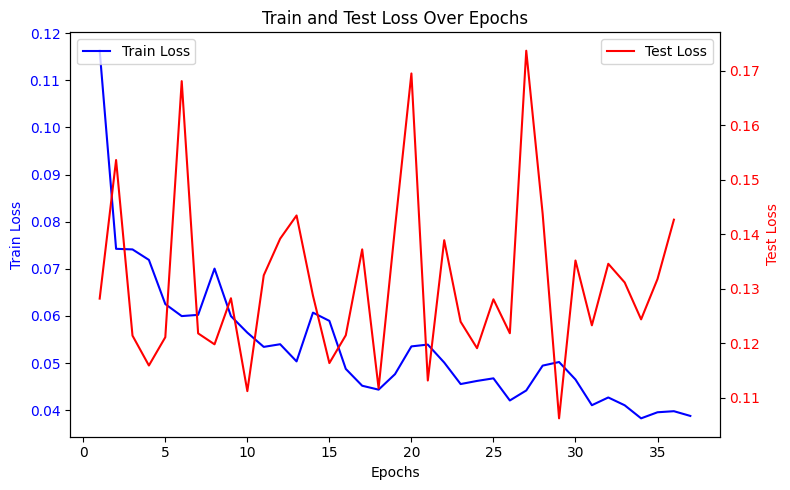

CARDformer(
  (W_input_projection): Linear(in_features=3, out_features=128, bias=True)
  (input_dropout): Dropout(p=0.1, inplace=False)
  (W_statistic): Linear(in_features=2, out_features=128, bias=True)
  (W_out): Linear(in_features=256, out_features=3, bias=True)
  (Attentions_over_token): ModuleList(
    (0-3): 4 x Attenion(
      (qkv): Linear(in_features=128, out_features=384, bias=True)
      (attn_dropout): Dropout(p=0.1, inplace=False)
      (norm_post1): Sequential(
        (0): Transpose()
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Transpose()
      )
      (norm_post2): Sequential(
        (0): Transpose()
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Transpose()
      )
      (norm_attn): Sequential(
        (0): Transpose()
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Transpose()
      )
 

In [43]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(range(1 ,len(test_loss_list) + 1), test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    
# Load model and Evaluate
model.load_state_dict(torch.load(f"./CARD{version}.pth"))  # 최적 모델 로드
model.eval()

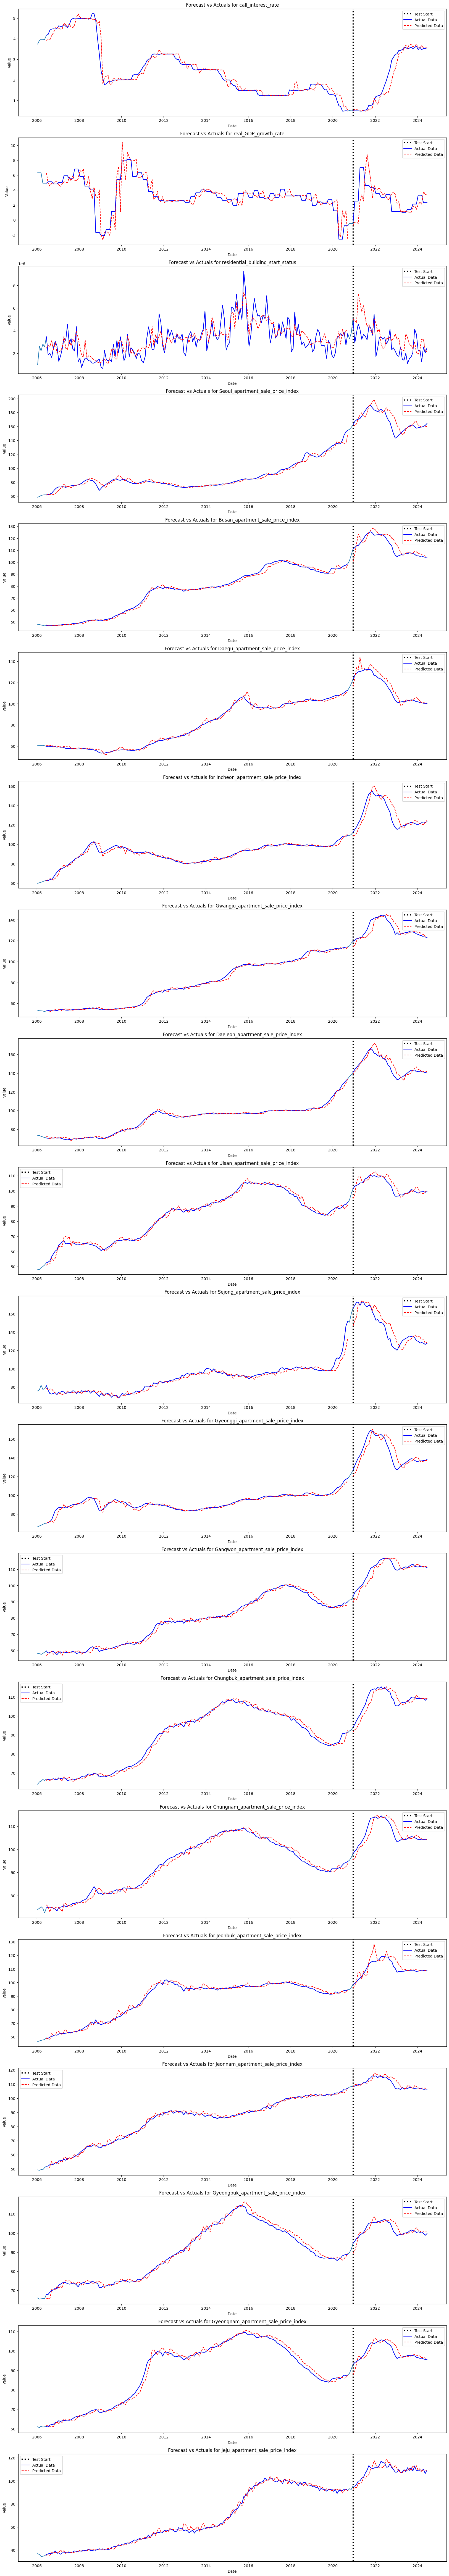

In [42]:
train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        data = data.permute(0, 2, 1)
        target = target.permute(0, 2, 1)
        train_output = model(data) # shape = (batch_size, channels, sequence_length)
        train_predicted = train_output[:, :, -1].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, :, -1].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        data = data.permute(0, 2, 1)
        target = target.permute(0, 2, 1)
        test_output = model(data)
        test_predicted = test_output[:, :, -1].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, :, -1].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df['Date'], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
 

### Train and Save model (Input V2: All variables used in FA-SEM-MLP)
* input: "call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg", "KOSPI_index", "KOSDAQ_index", "NASDAQ_index", "M2_Korea", "M2_USA", "broad_liquidity", "CPI_growth_rate", "USD_KRW_exchange_rate", "real_GDP_growth_rate", "residential_building_start_status", "residential_building_permit_status", "construction_production_index_seasonally_adjusted", 
f"{target}"
* window_size = 3
* forecast_size= 3 

In [44]:
### Experiment Setting
version = "V2"
### Experiment Setting
batch_size = 16
kernel_size = 25
epoch_ = 500
lr = 0.001
patience = 20  # easrly stopping

columns_to_use = column + nf.columns.tolist()
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len = window_size,              # 입력 시퀀스 길이
    patch_len = 3,                      # 각 패치의 길이
    stride = 2,                         # 패치 간격
    d_model = 128,                      # 모델의 hidden dimension
    pred_len = forecast_size,           # 예측 길이
    dropout = 0.1,                      # 드롭아웃 비율
    e_layers = 4,                       # 인코더 레이어 수
    n_heads = 8,                        # 멀티헤드 어텐션의 헤드 수
    use_statistic = True,               # 통계치 사용 여부
    total_token_number = 3,             # 총 토큰 수
    d_ff = 256,                         # Feedforward network의 차원
    momentum = 0.1,                     # 배치 정규화의 모멘템
    alpha = 0.3,                        # EMA 계수
    dp_rank = 16,                       # 동적 프로젝션의 랭크
    enc_in = len(columns_to_use),       # 입력 채널 수
    merge_size = 4,                     # 병합 크기
)

In [45]:
# Prepare Dataset
# 정규화된 train_df, test_df와 각 칼럼에 대한 mean_, std_ 딕셔너리가 출력됨. 
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
model = CARDformer(config=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

  7%|▋         | 37/500 [05:56<1:14:21,  9.64s/it]

Early stopping triggered.


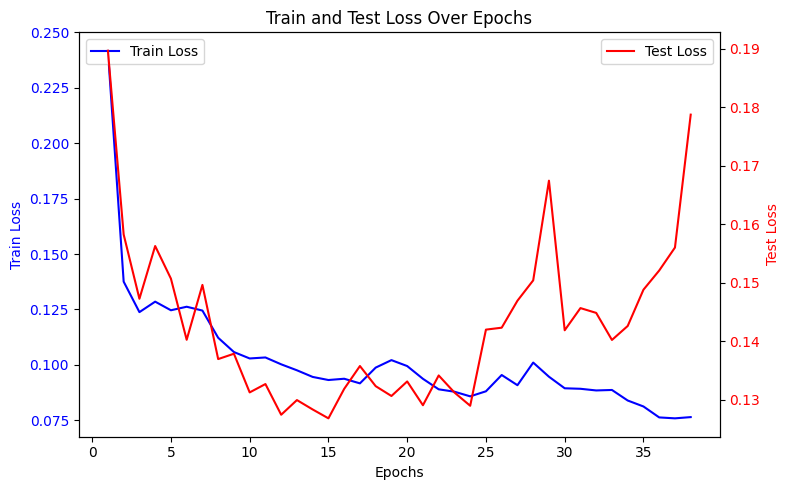

CARDformer(
  (W_input_projection): Linear(in_features=3, out_features=128, bias=True)
  (input_dropout): Dropout(p=0.1, inplace=False)
  (W_statistic): Linear(in_features=2, out_features=128, bias=True)
  (W_out): Linear(in_features=256, out_features=3, bias=True)
  (Attentions_over_token): ModuleList(
    (0-3): 4 x Attenion(
      (qkv): Linear(in_features=128, out_features=384, bias=True)
      (attn_dropout): Dropout(p=0.1, inplace=False)
      (norm_post1): Sequential(
        (0): Transpose()
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Transpose()
      )
      (norm_post2): Sequential(
        (0): Transpose()
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Transpose()
      )
      (norm_attn): Sequential(
        (0): Transpose()
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Transpose()
      )
 

In [46]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        
        optimizer.zero_grad()
        # print(data.permute(0, 2, 1).shape) # (batch_size, channels, sequence_length)
        output = model(data.permute(0, 2, 1))
        # print(target.permute(0, 2, 1).shape)
        loss = criterion(output, target.permute(0, 2, 1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = model(data.permute(0, 2, 1))
            test_loss = criterion(output, target.permute(0, 2, 1))
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(model.state_dict(), f"./CARD{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(range(1 ,len(test_loss_list) + 1), test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    
# Load model and Evaluate
model.load_state_dict(torch.load(f"./CARD{version}.pth"))  # 최적 모델 로드
model.eval()

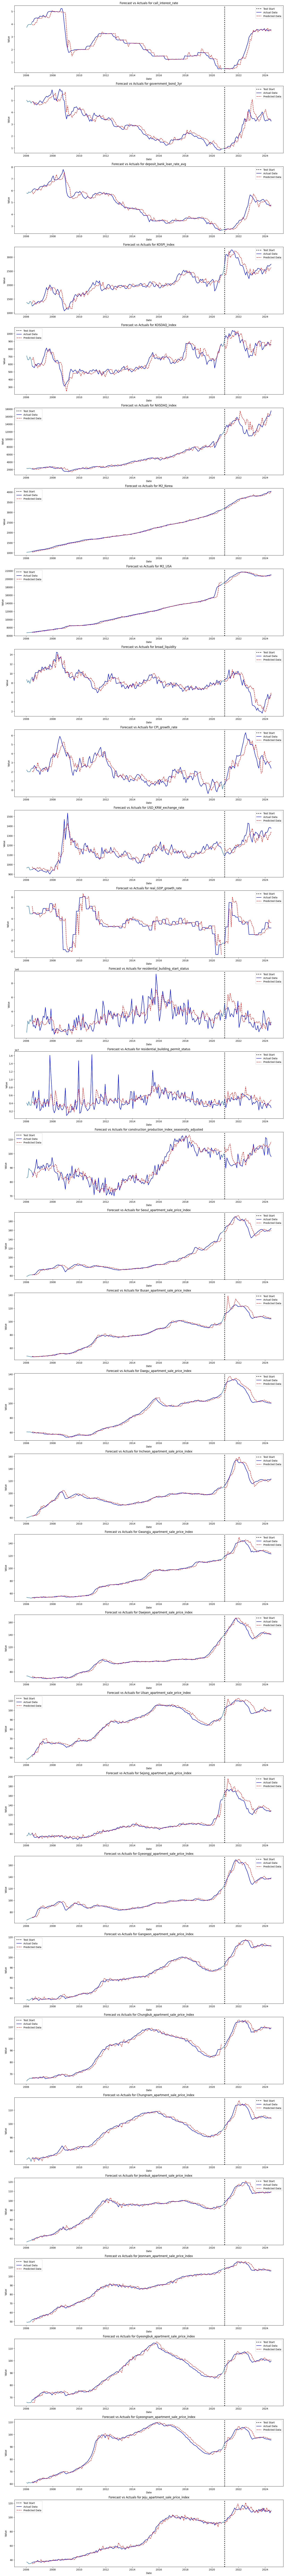

In [47]:
train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        data = data.permute(0, 2, 1)
        target = target.permute(0, 2, 1)
        train_output = model(data) # shape = (batch_size, channels, sequence_length)
        train_predicted = train_output[:, :, -1].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, :, -1].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        data = data.permute(0, 2, 1)
        target = target.permute(0, 2, 1)
        test_output = model(data)
        test_predicted = test_output[:, :, -1].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, :, -1].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df['Date'], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
 

### Train and Save model (Input V3: Just using Past target)
* input: f"{target}"
* window_size = 3
* forecast_size= 3 

In [48]:
### Experiment Setting
version = "V3"
window_size = 3
forecast_size= 3 
epoch_ = 500
lr = 0.001
patience = 20  # early stopping

columns_to_use = nf.columns.tolist()
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len = window_size,              # 입력 시퀀스 길이
    patch_len = 3,                      # 각 패치의 길이
    stride = 2,                         # 패치 간격
    d_model = 128,                      # 모델의 hidden dimension
    pred_len = forecast_size,           # 예측 길이
    dropout = 0.1,                      # 드롭아웃 비율
    e_layers = 4,                       # 인코더 레이어 수
    n_heads = 8,                        # 멀티헤드 어텐션의 헤드 수
    use_statistic = True,               # 통계치 사용 여부
    total_token_number = 3,             # 총 토큰 수
    d_ff = 256,                         # Feedforward network의 차원
    momentum = 0.1,                     # 배치 정규화의 모멘템
    alpha = 0.3,                        # EMA 계수
    dp_rank = 16,                       # 동적 프로젝션의 랭크
    enc_in = len(columns_to_use),       # 입력 채널 수
    merge_size = 4,                     # 병합 크기
)

In [49]:
# Prepare Dataset
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
model = CARDformer(config=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

  7%|▋         | 34/500 [03:46<51:43,  6.66s/it]  

Early stopping triggered.


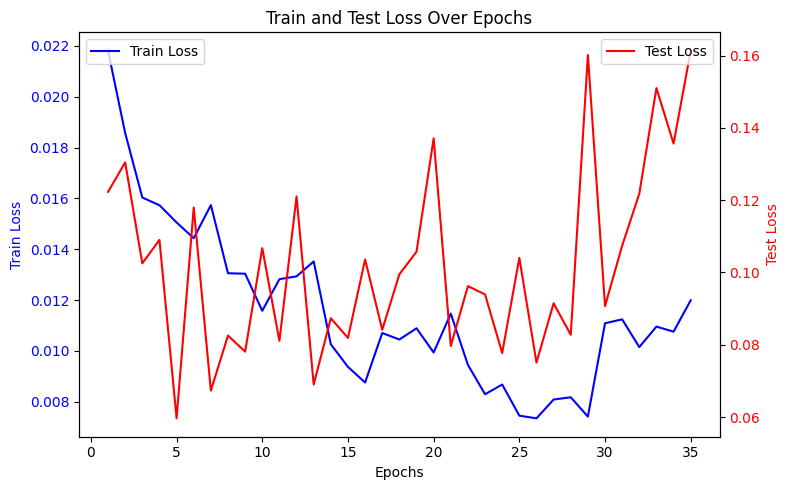

CARDformer(
  (W_input_projection): Linear(in_features=3, out_features=128, bias=True)
  (input_dropout): Dropout(p=0.1, inplace=False)
  (W_statistic): Linear(in_features=2, out_features=128, bias=True)
  (W_out): Linear(in_features=256, out_features=3, bias=True)
  (Attentions_over_token): ModuleList(
    (0-3): 4 x Attenion(
      (qkv): Linear(in_features=128, out_features=384, bias=True)
      (attn_dropout): Dropout(p=0.1, inplace=False)
      (norm_post1): Sequential(
        (0): Transpose()
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Transpose()
      )
      (norm_post2): Sequential(
        (0): Transpose()
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Transpose()
      )
      (norm_attn): Sequential(
        (0): Transpose()
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Transpose()
      )
 

In [50]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        
        optimizer.zero_grad()
        # print(data.permute(0, 2, 1).shape) # (batch_size, channels, sequence_length)
        output = model(data.permute(0, 2, 1))
        # print(target.permute(0, 2, 1).shape)
        loss = criterion(output, target.permute(0, 2, 1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = model(data.permute(0, 2, 1))
            test_loss = criterion(output, target.permute(0, 2, 1))
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(model.state_dict(), f"./CARD{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(range(1 ,len(test_loss_list) + 1), test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    
# Load model and Evaluate
model.load_state_dict(torch.load(f"./CARD{version}.pth"))  # 최적 모델 로드
model.eval()

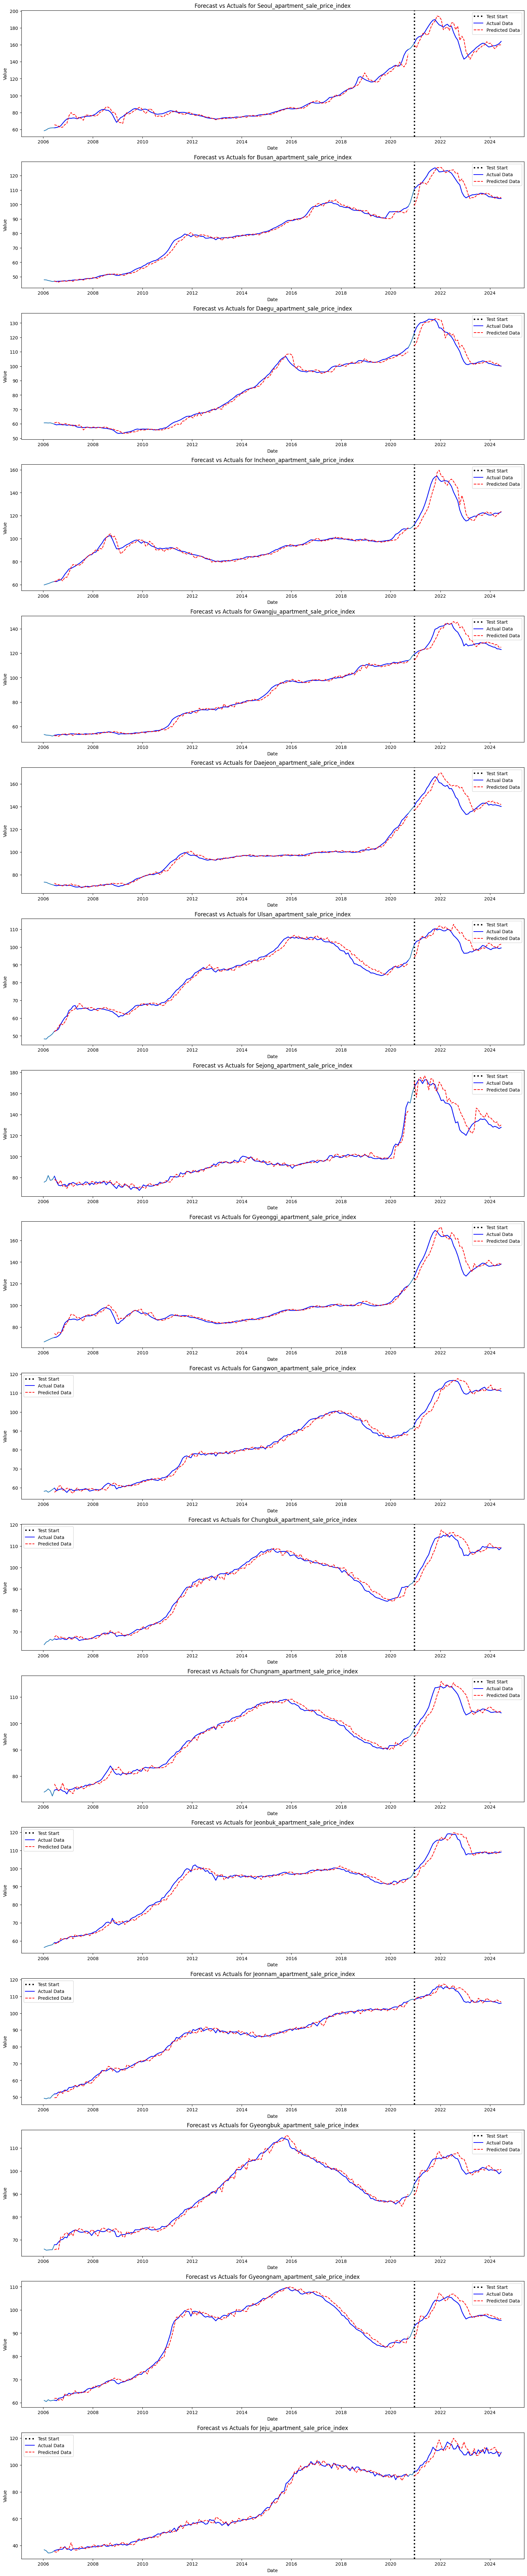

In [51]:
train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        data = data.permute(0, 2, 1)
        target = target.permute(0, 2, 1)
        train_output = model(data) # shape = (batch_size, channels, sequence_length)
        train_predicted = train_output[:, :, -1].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, :, -1].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        data = data.permute(0, 2, 1)
        target = target.permute(0, 2, 1)
        test_output = model(data)
        test_predicted = test_output[:, :, -1].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, :, -1].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df['Date'], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
 